In [9]:
import tensorflow as tf

print(tf.__version__)

2.3.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-24 19:02:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 74.125.206.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-24 19:02:21 (95.2 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



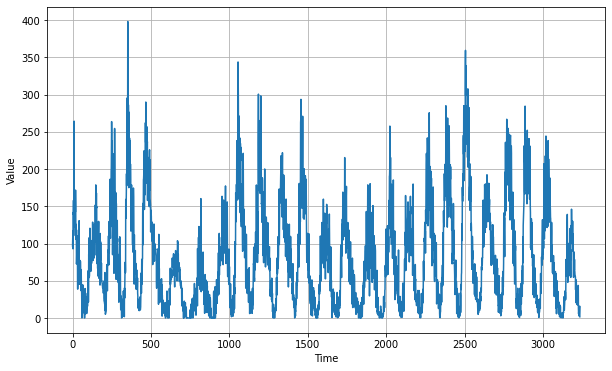

In [4]:
import csv

time_step = []
sunspots = []

with open("/tmp/sunspots.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [27]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [16]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 1s 52ms/step - loss: 81.4328 - mae: 81.9305
Epoch 2/100
12/12 [==============================] - 1s 56ms/step - loss: 80.2591 - mae: 80.7567
Epoch 3/100
12/12 [==============================] - 1s 53ms/step - loss: 78.5311 - mae: 79.0287
Epoch 4/100
12/12 [==============================] - 1s 54ms/step - loss: 76.5364 - mae: 77.0339
Epoch 5/100
12/12 [==============================] - 1s 53ms/step - loss: 74.4509 - mae: 74.9484
Epoch 6/100
12/12 [==============================] - 1s 53ms/step - loss: 72.3866 - mae: 72.8840
Epoch 7/100
12/12 [==============================] - 1s 53ms/step - loss: 70.4372 - mae: 70.9347
Epoch 8/100
12/12 [==============================] - 1s 53ms/step - loss: 68.6067 - mae: 69.1043
Epoch 9/100
12/12 [==============================] - 1s 60ms/step - loss: 66.9549 - mae: 67.4526
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

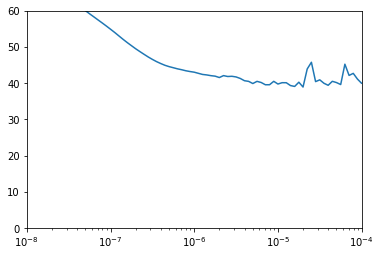

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [23]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=500)

Epoch 1/500
30/30 [==============================] - 1s 31ms/step - loss: 51.2723 - mae: 51.7702
Epoch 2/500
30/30 [==============================] - 1s 32ms/step - loss: 41.6310 - mae: 42.1282
Epoch 3/500
30/30 [==============================] - 1s 34ms/step - loss: 40.7379 - mae: 41.2352
Epoch 4/500
30/30 [==============================] - 1s 33ms/step - loss: 40.4494 - mae: 40.9465
Epoch 5/500
30/30 [==============================] - 1s 33ms/step - loss: 40.0288 - mae: 40.5261
Epoch 6/500
30/30 [==============================] - 1s 32ms/step - loss: 40.4046 - mae: 40.9018
Epoch 7/500
30/30 [==============================] - 1s 34ms/step - loss: 40.1636 - mae: 40.6608
Epoch 8/500
30/30 [==============================] - 1s 34ms/step - loss: 39.4108 - mae: 39.9079
Epoch 9/500
30/30 [==============================] - 1s 33ms/step - loss: 38.5436 - mae: 39.0407
Epoch 10/500
30/30 [==============================] - 1s 35ms/step - loss: 38.5593 - mae: 39.0562
Epoch 11/500
30/30 [=========

In [28]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

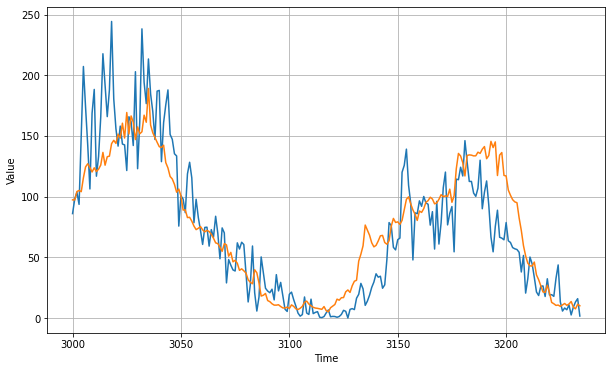

In [29]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

21.202574

<Figure size 432x288 with 0 Axes>

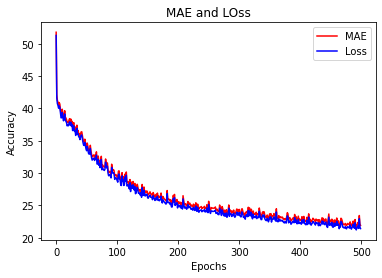

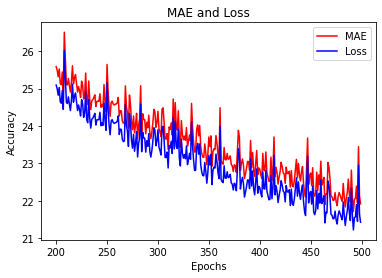

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.image as mpimg
import matplotlib


mae = history.history["mae"]
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')

plt.title("MAE and LOss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

# Plot zoomed MAE and Loss

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')

plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [33]:
print(rnn_forecast)

[ 97.3285     97.21459   104.158     105.08959   104.04166   115.49692
 124.48152   127.06555   123.92173   120.28627   123.74995   120.63842
 122.61022   125.97871   136.40411   125.872055  132.85928   133.32806
 143.6437    146.37349   143.84277   151.49849   148.25381   160.47218
 148.2532    169.29152   151.55724   166.4477    161.32614   146.9978
 157.41908   151.731     153.42203   167.09361   161.25443   189.11058
 158.96404   152.64185   148.60344   144.77594   141.12625   140.48848
 142.35509   127.99611   123.62402   116.58976   114.540955  110.1098
 103.643654  106.21211   100.5733     88.92119    89.041985   82.71708
  82.96323    79.80599    75.70307    72.79175    73.87509    75.35634
  72.58371    70.948044   72.13701    71.24169    68.94362    65.75259
  61.873363   61.28428    58.2785     54.917847   61.25195    60.249855
  50.901783   54.039074   46.27442    47.541866   45.053684   39.2528
  40.498756   38.880314   37.01156    31.444199   29.40917    28.204233
  39.72